### This is a notebook to format your data for segmentation, run the images through the cloud instance of Mesmer, and then extract marker counts and morphological information from all the cells in your images

In [130]:
# import required packages
import os
import warnings

import matplotlib.pyplot as plt
import numpy as np
import skimage.io as io
import xarray as xr
from alpineer import io_utils, load_utils

from ark.segmentation import marker_quantification, segmentation_utils
from ark.utils import (deepcell_service_utils, example_dataset,
                       plot_utils)

from deepcell.applications import Mesmer
from deepcell.datasets import multiplex_tissue

## 0: Set root directory and download example dataset

In [2]:
((X_train, y_train),(X_test, y_test)) = multiplex_tissue.load_data()

51920896/51905517 [==============================] - 252s 5us/step


In [12]:
X_train.shape

(16, 512, 512, 2)

In [118]:
def calc_n_tiles(dim, tile_size, overlap):
    n_tiles = (dim - overlap) / (tile_size - overlap)
    return(n_tiles)
                 
def create_orverlapping_tiles(dim1, dim2,  max_tile_size, overlap):
    tile_sizes = [*range(overlap+1,max_tile_size)]
    tile_sizes.reverse()
    
    res = 0
    
    for x in tile_sizes:
        if ((calc_n_tiles(dim1, x, overlap)).is_integer()) and ((calc_n_tiles(dim2, x, overlap)).is_integer()):
        # if (calc_n_tiles(dimx, x, overlap)).is_integer():
            res = x
            break
            
    if res == 0:
        raise Exception('could not find an appropriate tile size')
    else:
        return(res)

In [120]:
create_orverlapping_tiles(900, 900, 320, 100)

300

In [111]:
calc_n_tiles(900, 300, 100)

4.0

Here we are using the example data located in `/data/example_dataset/input_data`. To modify this notebook to run using your own data, simply change `base_dir` to point to your own sub-directory within the data folder.

* `base_dir`: the path to all of your imaging data. This directory will contain all of the data generated by this notebook.

In [121]:
# set up the base directory
base_dir = "../data/external/deep_cell"

If you would like to test the features in Ark with an example dataset, run the cell below. It will download a dataset consisting of 11 FOVs with 22 channels. You may find more information about the example dataset in the [README](../README.md#example-dataset).

If you are using your own data, skip the cell below.

* `overwrite_existing`: If set to `False`, it will not overwrite existing data in the `data/example_dataset`. Recommended leaving as `True` if you are doing a clean run of the `ark` pipeline using this dataset from the start. If you already have the dataset downloaded, set to `False`.

In [122]:
example_dataset.get_example_dataset(dataset="segment_image_data", save_dir = base_dir, overwrite_existing = True)

Generating segment_image_data split: 0 examples [00:00, ? examples/s]

Dataset ark_example downloaded and prepared to /root/.cache/huggingface/datasets/angelolab___ark_example/segment_image_data/0.0.5/1adf3ccc63f4f8bba80dfcad2afb9fe9a40fd51dc21bda5b4d307e6a615dfc01. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

## 1: set file paths and parameters

### All data, images, files, etc. must be placed in the 'data' directory, and referenced via '../data/path_to_your_data'

If you're interested in directly interfacing with Google Drive, consult the documentation [here](https://ark-analysis.readthedocs.io/en/latest/_rtd/google_docs_usage.html).

In [123]:
# set up file paths
tiff_dir = os.path.join(base_dir, "image_data")
cell_table_dir = os.path.join(base_dir, "segmentation/cell_table")
deepcell_input_dir = os.path.join(base_dir, "segmentation/deepcell_input")
deepcell_output_dir = os.path.join(base_dir, "segmentation/deepcell_output")
deepcell_visualization_dir = os.path.join(base_dir, "segmentation/deepcell_visualization")

In [124]:
# create directories if do not exist
for directory in [cell_table_dir, deepcell_input_dir, deepcell_output_dir, deepcell_visualization_dir]:
    if not os.path.exists(directory):
        os.makedirs(directory)

In [125]:
# validate paths
io_utils.validate_paths([base_dir,
                         tiff_dir,
                         deepcell_input_dir,
                         deepcell_output_dir,
                         cell_table_dir,
                         deepcell_visualization_dir
                         ])

### Compute and filter fov paths

In [126]:
# either get all fovs in the folder...
fovs = io_utils.list_folders(tiff_dir)

# ... or optionally, select a specific set of fovs manually
fovs = ["fov0"]

### Load images into notebook, process, and save as Mesmer compatable input

In [127]:
# NOTE: at least one of nucs and mems must not be None
# nuclear channel name(s) (or nucs = None)
nucs = ['H3K9ac', 'H3K27me3']

# membrane channel name(s) (or mems = None)
mems = ['CD14', 'CD45', 'ECAD']

In [10]:
# generate and save deepcell input tiffs
# set img_sub_folder param to None if the image files in tiff_dir are not in a separate sub folder 
# deepcell_service_utils.generate_deepcell_input(
#     deepcell_input_dir,
#     tiff_dir,
#     nucs,
#     mems,
#     fovs,
#     img_sub_folder=None
# )

### Prepare for local Mesmer analysis

In [196]:
def generate_local_deepcell_input(data_dir, tiff_dir, nuc_channels, mem_channels, fov,
                            is_mibitiff=False, img_sub_folder="TIFs", dtype="int16"):
    """Saves nuclear and membrane channels into deepcell input format.
    Either nuc_channels or mem_channels should be specified.

    Writes summed channel images out as multitiffs (channels first).

    Args:
        data_dir (str):
            location to save deepcell input tifs
        tiff_dir (str):
            directory containing folders of images, is_mibitiff determines what type
        nuc_channels (list):
            nuclear channels to be summed over
        mem_channels (list):
            membrane channels to be summed over
        fovs (list):
            list of folders to or MIBItiff files to load imgs from
        is_mibitiff (bool):
            if the images are of type MIBITiff
        img_sub_folder (str):
            if is_mibitiff is False, define the image subfolder for each fov
            ignored if is_mibitiff is True
        dtype (str/type):
            optional specifier of image type.  Overwritten with warning for float images
    Raises:
        ValueError:
            Raised if nuc_channels and mem_channels are both None or empty
    """

    # cannot have no nuclear and no membrane channels
    if not nuc_channels and not mem_channels:
        raise ValueError('Either nuc_channels or mem_channels should be non-empty.')

    # define the channels list by combining nuc_channels and mem_channels
    channels = (nuc_channels if nuc_channels else []) + (mem_channels if mem_channels else [])

    # filter channels for None (just in case)
    channels = [channel for channel in channels if channel is not None]

    # for fov in fovs:
    # load the images in the current fov batch
    if is_mibitiff:
        data_xr = load_utils.load_imgs_from_mibitiff(
            tiff_dir, mibitiff_files=[fov], channels=channels
        )
    else:
        data_xr = load_utils.load_imgs_from_tree(
            tiff_dir, img_sub_folder=img_sub_folder, fovs=[fov[0]], channels=channels
        )

    fov_name = data_xr.fovs.values[0]
    out = np.zeros((2, data_xr.shape[1], data_xr.shape[2]), dtype=data_xr.dtype)

    # sum over channels and add to output
    if nuc_channels:
        out[0] = np.sum(data_xr.loc[fov_name, :, :, nuc_channels].values, axis=2)
    if mem_channels:
        out[1] = np.sum(data_xr.loc[fov_name, :, :, mem_channels].values, axis=2)
    
    out = np.expand_dims(np.transpose(out, [1, 2, 0]), 0)
    
    return(out)

In [197]:
fov0_arr = generate_local_deepcell_input(
    deepcell_input_dir,
    tiff_dir,
    nucs,
    mems,
    fovs,
    img_sub_folder=None
)

In [198]:
fov0_arr.shape

(1, 512, 512, 2)

## 2: Upload files to Deepcell and download results

Deepcell input images will be zipped into a single file, uploaded to [deepcell.org](https://deepcell.org),

and the output will be downloaded to the deepcell output directory.

In [11]:
# Mesmer was trained on data acquired at 20X resolution. If your image data was acquired at a different resolution, you will get the best performance by rescaling. The rescale factor will increase or decrease the image resolution by the value you provide. For example, if you data was acquired at 10X, use a `rescale_factor` of 2. If your data was acquired at 60X resolution, use a `rescale_factor` of 0.33.
rescale_factor = 1.0

In [ ]:
# deepcell_service_utils.create_deepcell_output(deepcell_input_dir, deepcell_output_dir, fovs=fovs, scale=rescale_factor)

### Run deepcell locally

In [142]:
app = Mesmer()

96894976/96885295 [==============================] - 438s 5us/step


2023-05-10 14:46:23.671260: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.8/site-packages/cv2/../../lib64:
2023-05-10 14:46:23.671281: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-10 14:46:23.671292: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (6d546ffad1e5): /proc/driver/nvidia/version does not exist
2023-05-10 14:46:23.671442: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


ValueError: Input data must have 4 dimensions. Input data only has 3 dimensions

In [143]:
im = np.expand_dims(np.transpose(fov0_arr, [1, 2, 0]), 0)

In [144]:
im.shape

(1, 512, 512, 2)

In [199]:
segmentation_predictions = app.predict(fov0_arr, image_mpp=0.5)

In [174]:
labeled_image = np.zeros_like(im)
step_size = 128*2

In [186]:
[*range(0, labeled_image.shape[1], step_size)]

[0, 256]

In [176]:
im[:,:,:,:].shape

(1, 512, 512, 2)

In [1]:
def remove_boundary_mask(arr, boundary, boundary_sides)
    boundary_ids = list()
    for boundary_side in boundary_sides
        if "t" in boundary_side:
            boundary_mask = arr[:, 0:boundary, : , :]
            _boundary_ids = unqiue(boundary_mask)
            
        elif "b" in boundary_side:
            boundary_mask = arr[:, -boundary:, : , :]
            _boundary_ids = unqiue(boundary_mask)
        elif "r" in boundary_side:
            boundary_mask = arr[:, :, -boundary: , :]
            _boundary_ids = unqiue(boundary_mask)

        elif "l" in boundary_side:
            boundary_mask = arr[:, :, 0:boundary, :]
            _boundary_ids = unqiue(boundary_mask)
    cleaned_arr = copy(arr)
    cleaned_arr[arr[arr in boundary_ids]] = arr[arr in boundary_ids] - arr[arr in boundary_ids]
    return(cleaned_arr)
    

SyntaxError: invalid syntax (1360529311.py, line 1)

In [177]:
for row in range(0, labeled_image.shape[1], step_size):
      for col in range(0, labeled_image.shape[2], step_size):
            tmp_segmentation = app.predict(im[:, row:(row + step_size), col:(col + step_size),:])
            
            
            labeled_image[:, row:(row + step_size), col:(col + step_size), :] = app.predict(im[:, row:(row + step_size), col:(col + step_size),:])

In [208]:
np.unique(labeled_image[:,266:512,266:512,:])

array([  0.,   1.,   3.,   6.,   7.,   8.,   9.,  10.,  11.,  12.,  13.,
        14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,  24.,
        25.,  26.,  27.,  29.,  30.,  31.,  32.,  33.,  34.,  35.,  36.,
        37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,  46.,  47.,
        48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,  58.,
        59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.,  69.,
        70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,  79.,  80.,  81.,
        82.,  83.,  84.,  85.,  86.,  87.,  88.,  89.,  90.,  91.,  92.,
        93.,  94.,  95.,  96.,  97.,  98.,  99., 100., 101., 102., 103.,
       104., 105., 106., 107., 108., 109., 110., 111., 112., 113., 114.,
       115., 116., 117., 118., 119., 120., 121., 122., 123., 124., 125.,
       126., 127., 128., 129., 130., 131., 132., 133., 134., 135., 136.,
       137., 138., 139., 140., 141., 142., 143., 144., 145., 146., 147.,
       148., 149., 150., 151., 152., 153., 154., 15

In [2]:
segmentation_predictions

NameError: name 'segmentation_predictions' is not defined

In [209]:
np.unique(labeled_image[:,0:200,0:200,:])

array([  0.,   1.,   2.,   3.,   4.,   6.,   7.,   9.,  10.,  11.,  12.,
        13.,  14.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,  25.,  27.,
        28.,  30.,  31.,  32.,  33.,  34.,  35.,  37.,  40.,  41.,  42.,
        43.,  44.,  45.,  46.,  47.,  50.,  51.,  53.,  54.,  55.,  56.,
        57.,  59.,  60.,  61.,  62.,  63.,  65.,  66.,  67.,  68.,  69.,
        70.,  72.,  73.,  74.,  75.,  77.,  78.,  79.,  80.,  81.,  82.,
        83.,  84.,  86.,  87.,  88.,  89.,  91.,  92.,  93.,  94.,  95.,
        96.,  97.,  98.,  99., 100., 102., 103., 104., 106., 107., 108.,
       109., 110., 111., 112., 113., 116., 117., 118., 119., 121., 122.,
       123., 124., 125., 126., 127., 129., 130., 131., 135.],
      dtype=float32)

### We can then save the segmented mask overlaid on the imaging data

In [ ]:
# display the channel overlay for a fov, useful for quick verification
warnings.simplefilter("ignore")

fov_to_display = io_utils.remove_file_extensions([fovs[0]])[0]

fov_overlay = plot_utils.create_overlay(
    fov=fov_to_display,
    segmentation_dir=deepcell_output_dir,
    data_dir=deepcell_input_dir,
    img_overlay_chans=['nuclear_channel', 'membrane_channel'],
    seg_overlay_comp='whole_cell'
)

_ = io.imshow(fov_overlay)

In [147]:
from deepcell.utils.plot_utils import create_rgb_image

# create rgb overlay of image data for visualization
rgb_images = create_rgb_image(im, channel_colors=['green', 'blue'])

In [178]:
from deepcell.utils.plot_utils import make_outline_overlay
overlay_data = make_outline_overlay(rgb_data=rgb_images, predictions=segmentation_predictions)
overlay_data_tile = make_outline_overlay(rgb_data=rgb_images, predictions=labeled_image)

In [151]:
rgb_images.shape

(1, 512, 512, 3)

In [152]:
rgb_images_2 = create_rgb_image(X_train, channel_colors=['green', 'blue'])

In [153]:
rgb_images_2.shape

(16, 512, 512, 3)

In [195]:
print(labeled_image[0,247:248,400:410,0])

[[186. 186. 186. 186. 186. 186. 186. 186. 186. 186.]]


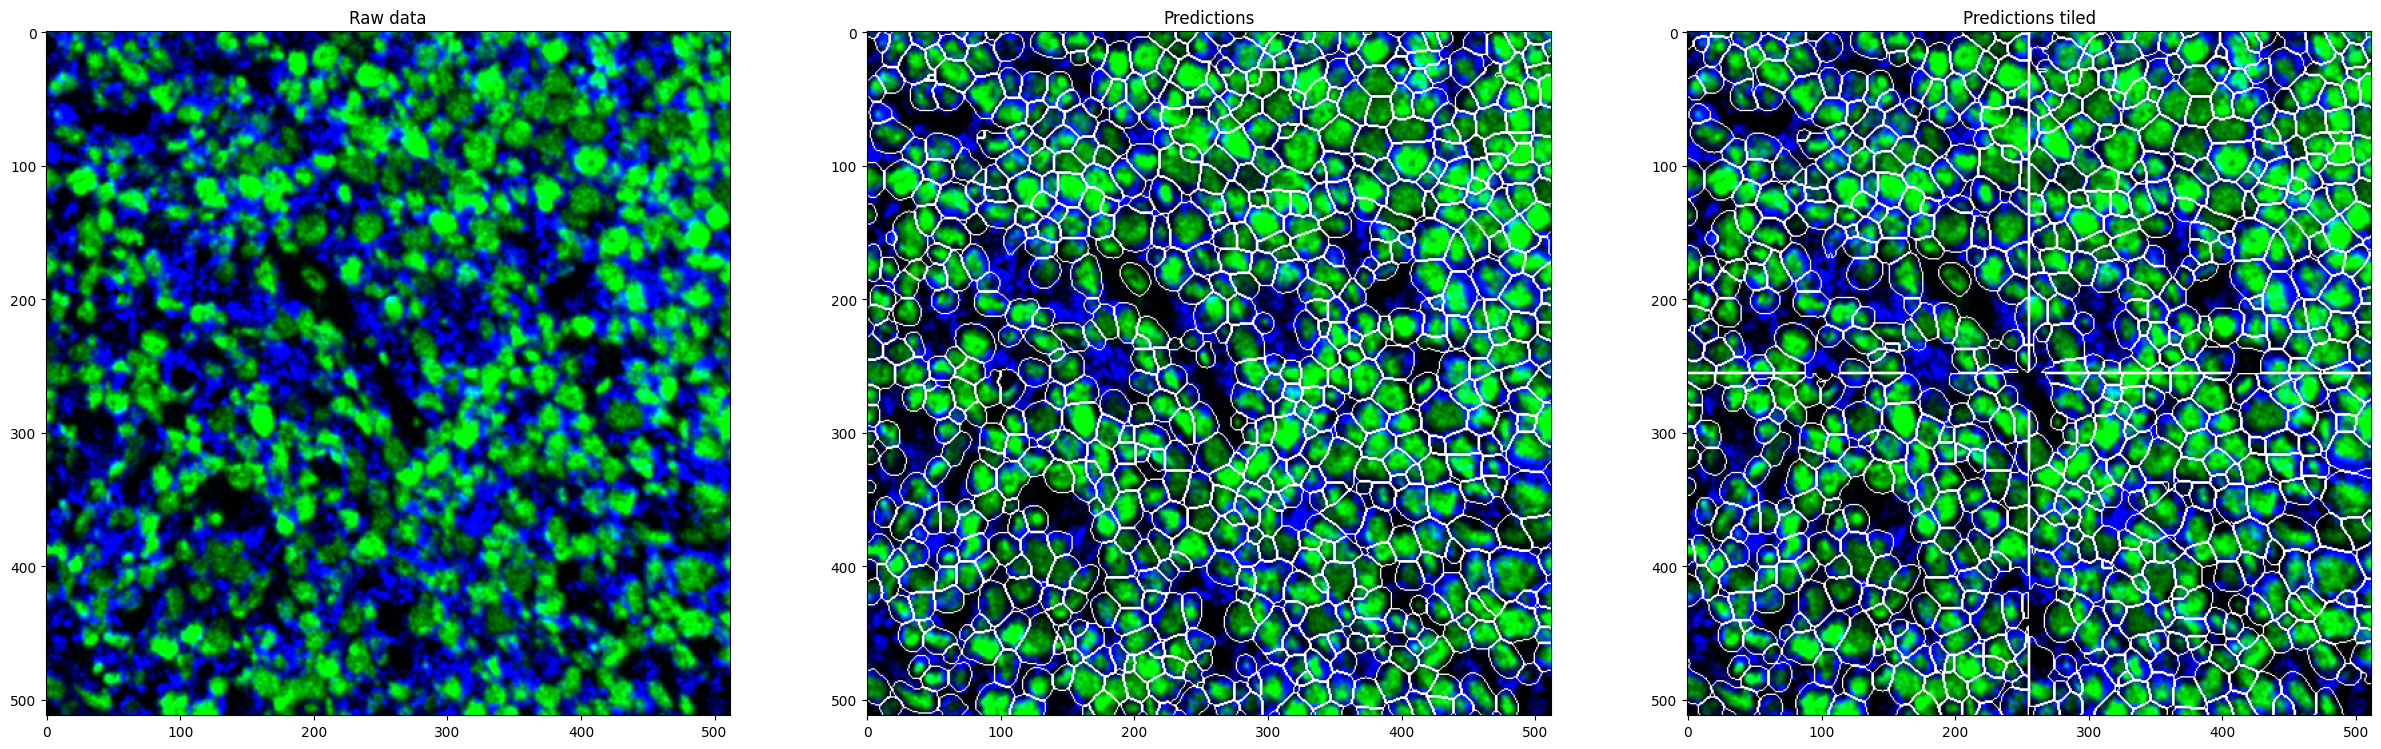

In [180]:
from matplotlib import pyplot as plt

# select index for displaying
idx = 0

# plot the data
fig, ax = plt.subplots(1, 3, figsize=(30, 30))
ax[0].imshow(rgb_images[idx, ...])
ax[1].imshow(overlay_data[idx, ...])
ax[2].imshow(overlay_data_tile[idx, ...])
ax[0].set_title('Raw data')
ax[1].set_title('Predictions')
ax[2].set_title('Predictions tiled')
plt.show()

In [ ]:
# save the overlaid segmentation labels for each fov (these will not display, but will save in viz_dir)
segmentation_utils.save_segmentation_labels(
    segmentation_dir=deepcell_output_dir,
    data_dir=deepcell_input_dir,
    output_dir=deepcell_visualization_dir,
    fovs=io_utils.remove_file_extensions(fovs),
    channels=['nuclear_channel', 'membrane_channel']
)

### Afterwards, we can generate expression matrices from the labeling + imaging data

In [ ]:
# set to True to add nuclear cell properties to the expression matrix
nuclear_counts = False

# set to True to bypass expensive cell property calculations
# only cell label, size, and centroid will be extracted if True
fast_extraction = False

For a full list of features extracted, please refer to the cell table section of: https://ark-analysis.readthedocs.io/en/latest/_rtd/data_types.html

In [ ]:
# now extract the segmented imaging data to create normalized and transformed expression matrices
# note that if you're loading your own dataset, please make sure all the imaging data is in the same folder
# with each fov given its own folder and all fovs having the same channels
cell_table_size_normalized, cell_table_arcsinh_transformed = \
    marker_quantification.generate_cell_table(segmentation_dir=deepcell_output_dir,
                                              tiff_dir=tiff_dir,
                                              img_sub_folder=None,
                                              fovs=fovs,
                                              batch_size=5,
                                              nuclear_counts=nuclear_counts,
                                              fast_extraction=fast_extraction)

In [ ]:
# Set the compression level if desired, ZSTD compression can offer up to a 60-70% reduction in file size.
# NOTE: Compressed `csv` files cannot be opened in Excel. They must be uncompressed beforehand.
compression = None

# Uncomment the line below to allow for compressed `csv` files.
# compression = {"method": "zstd", "level": 3}

cell_table_size_normalized.to_csv(os.path.join(cell_table_dir, 'cell_table_size_normalized.csv'),
                                  compression=compression, index=False)
cell_table_arcsinh_transformed.to_csv(os.path.join(cell_table_dir, 'cell_table_arcsinh_transformed.csv'),
                                      compression=compression, index=False)